##### 导入包

In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import seaborn as sns
from keras import metrics
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Flatten, Activation, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.layers import LeakyReLU, Lambda, Concatenate, ReLU
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import backend as K
from keras.utils import plot_model
from keras.initializers import RandomNormal
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.model_selection import train_test_split
from keras.layers import TimeDistributed
from keras.layers import Lambda
from sklearn.metrics import recall_score, f1_score, confusion_matrix
from numpy import vstack
from numpy import ones
from numpy import zeros
from keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv1D, Flatten
from keras import regularizers
from keras.regularizers import l1
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

##### 读取数据

In [2]:
# 读取错误数据集
smartlog_data_fault_A_df = pd.read_csv('smartlog_data_fault_A_df.csv')
smartlog_data_fault_B_df = pd.read_csv('smartlog_data_fault_B_df.csv')
smartlog_data_fault_A_df = smartlog_data_fault_A_df[smartlog_data_fault_A_df['dt'] <= smartlog_data_fault_A_df['fault_time']]
smartlog_data_fault_B_df = smartlog_data_fault_B_df[smartlog_data_fault_B_df['dt'] <= smartlog_data_fault_B_df['fault_time']]
smartlog_data_fault_A_df = smartlog_data_fault_A_df.drop_duplicates()
smartlog_data_fault_B_df = smartlog_data_fault_B_df.drop_duplicates()
smartlog_data_fault_A_df

,serial_number,model,smart_5raw,smart_4raw,smart_192raw,smart_12raw,smart_5_normalized,smart_7_normalized,dt,fault_time,first_observation_time,time_diff
0,disk_69492,1,0.0,5.0,4.0,5.0,100.0,90.0,2017-07-22,2017-10-27,2017-07-09,110
1,disk_69492,1,0.0,5.0,4.0,5.0,100.0,90.0,2017-07-19,2017-10-27,2017-07-09,110
2,disk_69492,1,0.0,5.0,4.0,5.0,100.0,90.0,2017-07-29,2017-10-27,2017-07-09,110
3,disk_69492,1,0.0,5.0,4.0,5.0,100.0,90.0,2017-07-16,2017-10-27,2017-07-09,110
4,disk_69492,1,0.0,5.0,4.0,5.0,100.0,90.0,2017-07-20,2017-10-27,2017-07-09,110
...,...,...,...,...,...,...,...,...,...,...,...,...
334279,disk_73603,1,427.0,27.0,25.0,26.0,97.0,84.0,2018-12-01,2018-12-04,2018-12-01,3
334280,disk_73603,1,429.0,27.0,25.0,26.0,97.0,84.0,2018-12-04,2018-12-04,2018-12-01,3
334281,disk_73603,1,428.0,27.0,25.0,26.0,97.0,84.0,2018-12-02,2018-12-04,2018-12-01,3
334282,disk_35598,1,18.0,9.0,8.0,9.0,100.0,95.0,2018-12-01,2018-12-02,2018-12-01,1


In [3]:
# 读取健康数据
smartlog_data_A_df = pd.read_csv('smartlog_data_A_df.csv')
smartlog_data_B_df = pd.read_csv('smartlog_data_B_df.csv')
smartlog_data_A_df = smartlog_data_A_df.sort_values(['serial_number', 'dt'])
smartlog_data_B_df = smartlog_data_B_df.sort_values(['serial_number', 'dt'])
smartlog_data_A_df = smartlog_data_A_df.drop_duplicates()
smartlog_data_B_df = smartlog_data_B_df.drop_duplicates()
smartlog_data_A_df

,serial_number,model,smart_5raw,smart_4raw,smart_192raw,smart_12raw,smart_5_normalized,smart_7_normalized,dt
16671,disk_0,1,0.0,17.0,16.0,17.0,100.0,90.0,2018-12-26
28129,disk_0,1,0.0,17.0,16.0,17.0,100.0,90.0,2018-12-27
25892,disk_0,1,0.0,17.0,16.0,17.0,100.0,90.0,2018-12-28
2284,disk_0,1,0.0,17.0,16.0,17.0,100.0,90.0,2018-12-29
25893,disk_0,1,0.0,17.0,16.0,17.0,100.0,90.0,2018-12-30
...,...,...,...,...,...,...,...,...,...
28531,disk_99951,1,0.0,5.0,4.0,5.0,100.0,90.0,2018-12-27
22021,disk_99951,1,0.0,5.0,4.0,5.0,100.0,90.0,2018-12-28
12329,disk_99951,1,0.0,5.0,4.0,5.0,100.0,90.0,2018-12-29
21625,disk_99951,1,0.0,5.0,4.0,5.0,100.0,90.0,2018-12-30


In [4]:
start_date = pd.to_datetime('2018-12-27')
end_date = pd.to_datetime('2018-12-31')
smartlog_data_A_df['dt'] = pd.to_datetime(smartlog_data_A_df['dt'])
smartlog_data_B_df['dt'] = pd.to_datetime(smartlog_data_B_df['dt'])
smartlog_data_A_df = smartlog_data_A_df[(smartlog_data_A_df['dt'] >= start_date) & (smartlog_data_A_df['dt'] <= end_date)]
smartlog_data_B_df = smartlog_data_B_df[(smartlog_data_B_df['dt'] >= start_date) & (smartlog_data_B_df['dt'] <= end_date)]

# 对'disk_id'进行分组，然后计数
disk_A_counts = smartlog_data_A_df.groupby('serial_number').size()
# 找到那些数据个数大于6的磁盘
disks_with_six_A = disk_A_counts[disk_A_counts >= 5].index
# 选择那些数据个数为6的磁盘的数据
smartlog_data_A_df = smartlog_data_A_df[smartlog_data_A_df['serial_number'].isin(disks_with_six_A)]

# 对'disk_id'进行分组，然后计数
disk_B_counts = smartlog_data_B_df.groupby('serial_number').size()
# 找到那些数据个数大于6的磁盘
disks_with_six_B = disk_B_counts[disk_B_counts >= 5].index
# 选择那些数据个数为6的磁盘的数据
smartlog_data_B_df = smartlog_data_B_df[smartlog_data_B_df['serial_number'].isin(disks_with_six_B)]

N = 1000  # 用你想要的磁盘数量替换
unique_disks_A = smartlog_data_A_df['serial_number'].unique()[:N]
unique_disks_B = smartlog_data_B_df['serial_number'].unique()[:N]
smartlog_data_A_df = smartlog_data_A_df[smartlog_data_A_df['serial_number'].isin(unique_disks_A)]
smartlog_data_B_df = smartlog_data_B_df[smartlog_data_B_df['serial_number'].isin(unique_disks_B)]

smartlog_data_A_df = smartlog_data_A_df[['serial_number', 'smart_5raw', 'smart_4raw', 'smart_192raw', 'smart_12raw', 'smart_5_normalized', 'smart_7_normalized', 'dt']]
smartlog_data_B_df = smartlog_data_B_df[['serial_number', 'smart_9_normalized', 'smart_191_normalized', 'smart_192raw', 'smart_195_normalized', 'smart_5raw', 'smart_199raw', 'smart_190_normalized', 'smart_188raw', 'smart_194_normalized', 'smart_194raw', 'smart_190raw' , 'smart_191raw', 'smart_7_normalized', 'smart_9raw', 'smart_7raw', 'smart_242raw', 'smart_241raw', 'dt']]
smartlog_data_A_df

,serial_number,smart_5raw,smart_4raw,smart_192raw,smart_12raw,smart_5_normalized,smart_7_normalized,dt
28129,disk_0,0.0,17.0,16.0,17.0,100.0,90.0,2018-12-27
25892,disk_0,0.0,17.0,16.0,17.0,100.0,90.0,2018-12-28
2284,disk_0,0.0,17.0,16.0,17.0,100.0,90.0,2018-12-29
25893,disk_0,0.0,17.0,16.0,17.0,100.0,90.0,2018-12-30
20013,disk_0,0.0,17.0,16.0,17.0,100.0,90.0,2018-12-31
...,...,...,...,...,...,...,...,...
20104,disk_11711,0.0,18.0,17.0,18.0,100.0,93.0,2018-12-27
9838,disk_11711,0.0,18.0,17.0,18.0,100.0,93.0,2018-12-28
8173,disk_11711,0.0,18.0,17.0,18.0,100.0,93.0,2018-12-29
3553,disk_11711,0.0,18.0,17.0,18.0,100.0,93.0,2018-12-30


##### 数据处理

In [5]:
# 故障磁盘数据处理
smartlog_data_fault_A_df['fault_time'] = pd.to_datetime(smartlog_data_fault_A_df['fault_time'])
smartlog_data_fault_A_df['dt'] = pd.to_datetime(smartlog_data_fault_A_df['dt'])
smartlog_data_fault_A_df = smartlog_data_fault_A_df[pd.Timedelta(days=4) >= (smartlog_data_fault_A_df['fault_time']-smartlog_data_fault_A_df['dt'])]
# 对'disk_id'进行分组，然后计数
disk_A_counts = smartlog_data_fault_A_df.groupby('serial_number').size()
# 找到那些数据个数大于6的磁盘
disks_with_six_A = disk_A_counts[disk_A_counts >= 5].index
# 选择那些数据个数为6的磁盘的数据
smartlog_data_fault_A_df = smartlog_data_fault_A_df[smartlog_data_fault_A_df['serial_number'].isin(disks_with_six_A)]

smartlog_data_fault_B_df['fault_time'] = pd.to_datetime(smartlog_data_fault_B_df['fault_time'])
smartlog_data_fault_B_df['dt'] = pd.to_datetime(smartlog_data_fault_B_df['dt'])
smartlog_data_fault_B_df = smartlog_data_fault_B_df[pd.Timedelta(days=4) >= (smartlog_data_fault_B_df['fault_time']-smartlog_data_fault_B_df['dt'])]
# 对'disk_id'进行分组，然后计数
disk_B_counts = smartlog_data_fault_B_df.groupby('serial_number').size()
# 找到那些数据个数大于6的磁盘
disks_with_six_B = disk_B_counts[disk_B_counts >= 5].index
# 选择那些数据个数为6的磁盘的数据
smartlog_data_fault_B_df = smartlog_data_fault_B_df[smartlog_data_fault_B_df['serial_number'].isin(disks_with_six_B)]
# 选取属性进行测试
smartlog_data_fault_A_df = smartlog_data_fault_A_df[['serial_number', 'smart_5raw', 'smart_4raw', 'smart_192raw', 'smart_12raw', 'smart_5_normalized', 'smart_7_normalized', 'dt']]
smartlog_data_fault_B_df = smartlog_data_fault_B_df[['serial_number', 'smart_9_normalized', 'smart_191_normalized', 'smart_192raw', 'smart_195_normalized', 'smart_5raw', 'smart_199raw', 'smart_190_normalized', 'smart_188raw', 'smart_194_normalized', 'smart_194raw', 'smart_190raw' , 'smart_191raw', 'smart_7_normalized', 'smart_9raw', 'smart_7raw', 'smart_242raw', 'smart_241raw', 'dt']]

# 排序
smartlog_data_fault_A_df = smartlog_data_fault_A_df.sort_values(['serial_number', 'dt'])
smartlog_data_fault_B_df = smartlog_data_fault_B_df.sort_values(['serial_number', 'dt'])
smartlog_data_fault_A_df

,serial_number,smart_5raw,smart_4raw,smart_192raw,smart_12raw,smart_5_normalized,smart_7_normalized,dt
47198,disk_100102,1.0,21.0,20.0,21.0,100.0,87.0,2017-09-25
47208,disk_100102,2.0,21.0,20.0,21.0,100.0,87.0,2017-09-26
47215,disk_100102,10.0,21.0,20.0,21.0,100.0,87.0,2017-09-27
47217,disk_100102,10.0,21.0,20.0,21.0,100.0,87.0,2017-09-28
47200,disk_100102,10.0,21.0,20.0,21.0,100.0,87.0,2017-09-29
...,...,...,...,...,...,...,...,...
215261,disk_99991,1333.0,8.0,7.0,8.0,92.0,87.0,2018-03-18
215272,disk_99991,1333.0,8.0,7.0,8.0,92.0,87.0,2018-03-19
215258,disk_99991,1333.0,8.0,7.0,8.0,92.0,87.0,2018-03-20
215262,disk_99991,1333.0,8.0,7.0,8.0,92.0,87.0,2018-03-21


In [6]:
# 合并数据集
data_A_df = pd.concat([smartlog_data_A_df, smartlog_data_fault_A_df])
data_B_df = pd.concat([smartlog_data_B_df, smartlog_data_fault_B_df])
numerical_cols = data_A_df.select_dtypes(include=[np.number]).columns
data_A_df[numerical_cols] = data_A_df[numerical_cols].fillna(data_A_df[numerical_cols].mean())

numerical_cols = data_B_df.select_dtypes(include=[np.number]).columns
data_B_df[numerical_cols] = data_B_df[numerical_cols].fillna(data_B_df[numerical_cols].mean())

data_B_df

,serial_number,smart_9_normalized,smart_191_normalized,smart_192raw,smart_195_normalized,smart_5raw,smart_199raw,smart_190_normalized,smart_188raw,smart_194_normalized,smart_194raw,smart_190raw,smart_191raw,smart_7_normalized,smart_9raw,smart_7raw,smart_242raw,smart_241raw,dt
29205,disk_100015,96.0,75.0,73.0,12.0,0.0,0.0,72.0,0.0,28.0,28.0,28.0,50754.0,89.0,3750.0,738422955.0,1.834500e+11,7.003266e+11,2018-12-27
11949,disk_100015,96.0,75.0,74.0,10.0,0.0,0.0,72.0,0.0,28.0,28.0,28.0,51171.0,89.0,3774.0,743557472.0,1.846467e+11,7.042397e+11,2018-12-28
21909,disk_100015,96.0,75.0,74.0,9.0,0.0,0.0,72.0,0.0,28.0,28.0,28.0,51547.0,89.0,3798.0,748656566.0,1.857101e+11,7.077721e+11,2018-12-29
23567,disk_100015,96.0,75.0,74.0,11.0,0.0,0.0,71.0,0.0,29.0,29.0,29.0,51912.0,89.0,3822.0,753626244.0,1.867968e+11,7.114810e+11,2018-12-30
8902,disk_100015,96.0,74.0,75.0,12.0,0.0,0.0,71.0,0.0,29.0,29.0,29.0,52294.0,89.0,3846.0,758640037.0,1.876792e+11,7.150725e+11,2018-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197350,disk_9996,96.0,100.0,86.0,24.0,0.0,0.0,75.0,0.0,25.0,25.0,25.0,1961.0,87.0,4273.0,466104276.0,1.888348e+10,2.659292e+10,2018-07-03
197355,disk_9996,96.0,100.0,87.0,25.0,0.0,0.0,75.0,0.0,25.0,25.0,25.0,1967.0,87.0,4297.0,469858412.0,1.910431e+10,2.664018e+10,2018-07-04
197351,disk_9996,96.0,100.0,87.0,25.0,0.0,0.0,75.0,0.0,25.0,25.0,25.0,1973.0,87.0,4321.0,473370383.0,1.935259e+10,2.668488e+10,2018-07-05
197354,disk_9996,96.0,100.0,88.0,25.0,0.0,0.0,75.0,0.0,25.0,25.0,25.0,1977.0,87.0,4345.0,476955717.0,1.959785e+10,2.672687e+10,2018-07-06


In [7]:
# 将A类型的数据转换成数组
grouped_A = data_A_df.groupby('serial_number')
grouped_fault_A = smartlog_data_fault_A_df.groupby('serial_number')
data_A = []
data_fault_A = []
for _, group in grouped_A:
    # 删除'serial_number', 'dt'列，然后将剩余的DataFrame转换为numpy数组
    disk_data_A = group.drop(columns=['serial_number', 'dt']).to_numpy()
    data_A.append(disk_data_A)
# 将数据堆叠在一起以形成一个形状为(1882, 5, 特征数量)的数组
for _, group in grouped_fault_A:
    # 删除'serial_number', 'dt'列，然后将剩余的DataFrame转换为numpy数组
    disk_data_A = group.drop(columns=['serial_number', 'dt']).to_numpy()
    data_fault_A.append(disk_data_A)
data_A = np.stack(data_A)
data_fault_A = np.stack(data_fault_A)
data_fault_A

array([[[1.000e+00, 2.100e+01, 2.000e+01, 2.100e+01, 1.000e+02,
         8.700e+01],
        [2.000e+00, 2.100e+01, 2.000e+01, 2.100e+01, 1.000e+02,
         8.700e+01],
        [1.000e+01, 2.100e+01, 2.000e+01, 2.100e+01, 1.000e+02,
         8.700e+01],
        [1.000e+01, 2.100e+01, 2.000e+01, 2.100e+01, 1.000e+02,
         8.700e+01],
        [1.000e+01, 2.100e+01, 2.000e+01, 2.100e+01, 1.000e+02,
         8.700e+01]],

       [[1.100e+02, 1.000e+01, 9.000e+00, 1.000e+01, 1.000e+02,
         9.400e+01],
        [1.100e+02, 1.000e+01, 9.000e+00, 1.000e+01, 1.000e+02,
         9.400e+01],
        [1.100e+02, 1.000e+01, 9.000e+00, 1.000e+01, 1.000e+02,
         9.400e+01],
        [1.100e+02, 1.000e+01, 9.000e+00, 1.000e+01, 1.000e+02,
         9.400e+01],
        [1.310e+02, 1.000e+01, 9.000e+00, 1.000e+01, 1.000e+02,
         9.400e+01]],

       [[2.600e+01, 2.500e+01, 2.400e+01, 2.500e+01, 1.000e+02,
         8.700e+01],
        [2.600e+01, 2.500e+01, 2.400e+01, 2.500e+01, 1.000e+0

In [8]:
data_A = np.log1p(data_A)
data_fault_A = np.log1p(data_fault_A)
data_fault_A


array([[[0.69314718, 3.09104245, 3.04452244, 3.09104245, 4.61512052,
         4.47733681],
        [1.09861229, 3.09104245, 3.04452244, 3.09104245, 4.61512052,
         4.47733681],
        [2.39789527, 3.09104245, 3.04452244, 3.09104245, 4.61512052,
         4.47733681],
        [2.39789527, 3.09104245, 3.04452244, 3.09104245, 4.61512052,
         4.47733681],
        [2.39789527, 3.09104245, 3.04452244, 3.09104245, 4.61512052,
         4.47733681]],

       [[4.7095302 , 2.39789527, 2.30258509, 2.39789527, 4.61512052,
         4.55387689],
        [4.7095302 , 2.39789527, 2.30258509, 2.39789527, 4.61512052,
         4.55387689],
        [4.7095302 , 2.39789527, 2.30258509, 2.39789527, 4.61512052,
         4.55387689],
        [4.7095302 , 2.39789527, 2.30258509, 2.39789527, 4.61512052,
         4.55387689],
        [4.88280192, 2.39789527, 2.30258509, 2.39789527, 4.61512052,
         4.55387689]],

       [[3.29583687, 3.25809654, 3.21887582, 3.25809654, 4.61512052,
         4.477336

In [9]:
# 将B类型的数据转换成数组
grouped_B = data_B_df.groupby('serial_number')
grouped_fault_B = smartlog_data_fault_B_df.groupby('serial_number')
data_B = []
data_fault_B = []
for _, group in grouped_B:
    # 删除'serial_number', 'dt'列，然后将剩余的DataFrame转换为numpy数组
    disk_data_B = group.drop(columns=['serial_number', 'dt']).to_numpy()
    data_B.append(disk_data_B)

for _, group in grouped_fault_B:
    # 删除'serial_number', 'dt'列，然后将剩余的DataFrame转换为numpy数组
    disk_data_B = group.drop(columns=['serial_number', 'dt']).to_numpy()
    data_fault_B.append(disk_data_B)

data_B = np.stack(data_B)
data_fault_B = np.stack(data_fault_B)
data_fault_B

array([[[1.00000000e+02, 1.00000000e+02, 8.00000000e+00, ...,
         4.75156860e+07, 1.04326195e+10, 2.14921218e+10],
        [1.00000000e+02, 1.00000000e+02, 8.00000000e+00, ...,
         5.05194090e+07, 1.12697852e+10, 2.28881365e+10],
        [1.00000000e+02, 1.00000000e+02, 9.00000000e+00, ...,
         5.35243840e+07, 1.20880066e+10, 2.41337017e+10],
        [1.00000000e+02, 1.00000000e+02, 9.00000000e+00, ...,
         5.65680200e+07, 1.28889912e+10, 2.52882923e+10],
        [1.00000000e+02, 1.00000000e+02, 9.00000000e+00, ...,
         5.96265470e+07, 1.36661508e+10, 2.63790951e+10]],

       [[9.90000000e+01, 9.90000000e+01, 5.50000000e+01, ...,
         2.78603306e+08, 3.86846544e+10, 5.77581415e+10],
        [9.90000000e+01, 9.90000000e+01, 5.60000000e+01, ...,
         2.84356545e+08, 3.91831155e+10, 6.21767102e+10],
        [9.90000000e+01, 9.90000000e+01, 5.60000000e+01, ...,
         2.90462961e+08, 4.01413597e+10, 6.36467943e+10],
        [9.90000000e+01, 9.90000000e+0

In [10]:
data_B = np.log1p(data_B)
data_fault_B = np.log1p(data_fault_B)
data_fault_B


array([[[ 4.61512052,  4.61512052,  2.19722458, ..., 17.67657047,
         23.06820322, 23.79095228],
        [ 4.61512052,  4.61512052,  2.19722458, ..., 17.73786818,
         23.14539111, 23.85388456],
        [ 4.61512052,  4.61512052,  2.30258509, ..., 17.7956479 ,
         23.21547961, 23.90687511],
        [ 4.61512052,  4.61512052,  2.30258509, ..., 17.85095438,
         23.27963939, 23.95360737],
        [ 4.61512052,  4.61512052,  2.30258509, ..., 17.90361147,
         23.33818787, 23.99583768]],

       [[ 4.60517019,  4.60517019,  4.02535169, ..., 19.44529949,
         24.37870883, 24.77953015],
        [ 4.60517019,  4.60517019,  4.04305127, ..., 19.46573945,
         24.39151176, 24.85324633],
        [ 4.60517019,  4.60517019,  4.04305127, ..., 19.48698663,
         24.41567305, 24.8766148 ],
        [ 4.60517019,  4.60517019,  4.06044301, ..., 19.50592826,
         24.43017668, 24.87708771],
        [ 4.60517019,  4.60517019,  4.07753744, ..., 19.52509211,
         24.44

##### LSTM模型

In [11]:
n_samples_A = 1882
n_timesteps_A = 4
n_features_A = 6

# 输入X是前4天的数据，输出y是第5天的数据
X_A = data_A[:, :4, :]
y_A = data_A[:, 4, :]
print(y_A.shape)

(1882, 6)


In [12]:
n_samples_B = 1894
n_timesteps_B = 4
n_features_B = 17

# 输入X是前4天的数据，输出y是第5天的数据
X_B = data_B[:, :4, :]
y_B = data_B[:, 4, :]
print(X_B.shape)

(1894, 4, 17)


In [13]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.13.0


param_grid = {  
    'neurons': np.arange(5,100),   
    'activation': ['relu', 'tanh', 'sigmoid', 'linear'],  
    'optimizer': ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam']  
}

In [14]:
# 构建A模型
model_A = Sequential()
model_A.add(LSTM(50, return_sequences=True, input_shape=(n_timesteps_A, n_features_A)))
model_A.add(LeakyReLU())
model_A.add(Dropout(0.2))
# model_A.add(LSTM(100, return_sequences=True))
# model_A.add(LeakyReLU())
# model_A.add(Dropout(0.2))
# model_A.add(LSTM(60, return_sequences=True))
# model_A.add(LeakyReLU())
# model_A.add(Dropout(0.2))
# model_A.add(LSTM(30, return_sequences=True))
# model_A.add(LeakyReLU())
# model_A.add(Dropout(0.2))
model_A.add(LSTM(15, return_sequences=False))
model_A.add(LeakyReLU())
model_A.add(Dropout(0.2))
model_A.add(Dense(n_features_A)) 
optimizer = Adam(learning_rate=0.001)
model_A.compile(optimizer=optimizer, loss='mse')


plot_model(model_A, to_file='model_A.png', show_shapes=True, show_dtype=True)
# 划分训练集和验证集
X_A_train, X_A_val, y_A_train, y_A_val = train_test_split(X_A, y_A, test_size=0.2, random_state=42)
# 训练模型，同时使用验证集
history_A = model_A.fit(X_A_train, y_A_train, validation_data=(X_A_val, y_A_val), epochs=1600, verbose=1)
# 获取训练和验证损失
train_loss_A = history_A.history['loss']
val_loss_A = history_A.history['val_loss']


Epoch 1/1600
48/48 [==============================] - 5s 21ms/step - loss: 9.5392 - val_loss: 6.8752
Epoch 2/1600
48/48 [==============================] - 0s 6ms/step - loss: 5.5555 - val_loss: 3.9031
Epoch 3/1600
48/48 [==============================] - 0s 6ms/step - loss: 3.5447 - val_loss: 2.6237
Epoch 4/1600
48/48 [==============================] - 0s 6ms/step - loss: 2.6525 - val_loss: 1.9852
Epoch 5/1600
48/48 [==============================] - 0s 6ms/step - loss: 2.2226 - val_loss: 1.6118
Epoch 6/1600
48/48 [==============================] - 0s 5ms/step - loss: 1.9186 - val_loss: 1.3802
Epoch 7/1600
48/48 [==============================] - 0s 5ms/step - loss: 1.7255 - val_loss: 1.2367
Epoch 8/1600
48/48 [==============================] - 0s 6ms/step - loss: 1.6563 - val_loss: 1.1447
Epoch 9/1600
48/48 [==============================] - 0s 6ms/step - loss: 1.5436 - val_loss: 1.0886
Epoch 10/1600
48/48 [==============================] - 0s 6ms/step - loss: 1.5470 - val_loss: 1.051

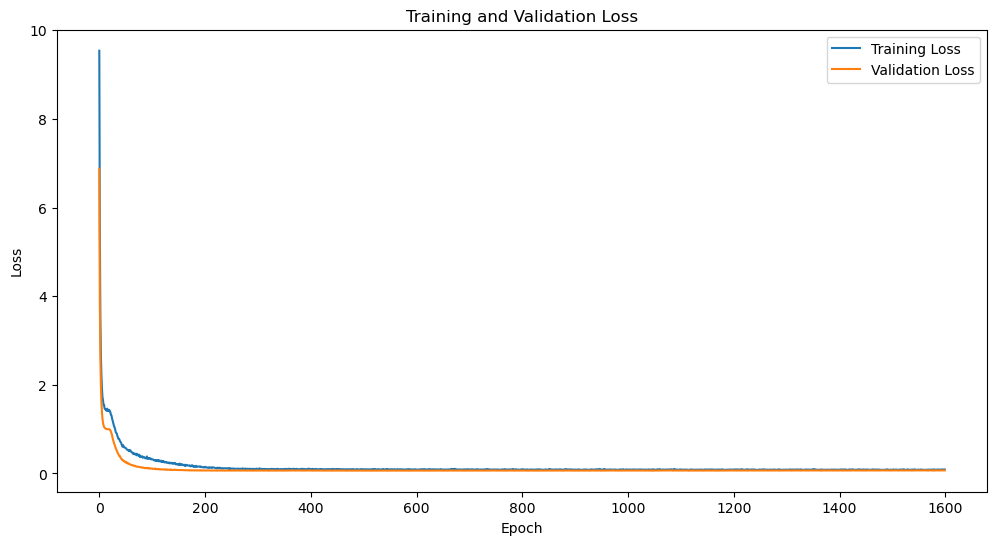

In [15]:
# 绘制损失曲线
plt.figure(figsize=(12, 6))
plt.plot(train_loss_A, label='Training Loss')
plt.plot(val_loss_A, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_curve_modelA.png')
plt.show()

param_grid = {  
    'neurons': np.arange(5,100),  
    'activation': ['relu', 'tanh', 'sigmoid', 'linear'],  
    'optimizer': ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam']  
}

In [16]:
# 构建B模型
model_B = Sequential()
model_B.add(LSTM(60, return_sequences=True, input_shape=(n_timesteps_B, n_features_B)))
model_B.add(LeakyReLU())
model_B.add(Dropout(0.2))
# model_B.add(LSTM(120, return_sequences=True))
# model_B.add(LeakyReLU())
# model_B.add(Dropout(0.2))
# model_B.add(LSTM(60, return_sequences=True))
# model_B.add(LeakyReLU())
# model_B.add(Dropout(0.2))
model_B.add(LSTM(20, return_sequences=False))
model_B.add(LeakyReLU())
model_B.add(Dropout(0.2))
# model_B.add(LSTM(16, return_sequences=False))
# model_B.add(LeakyReLU())
# model_B.add(Dropout(0.2))
model_B.add(Dense(n_features_B)) 
# model_B.add(LSTM(17, return_sequences=False))
optimizer = Adam(learning_rate=0.001)
model_B.compile(optimizer=optimizer, loss='mse')


plot_model(model_B, to_file='model_B.png', show_shapes=True, show_dtype=True)
# 划分训练集和验证集
X_B_train, X_B_val, y_B_train, y_B_val = train_test_split(X_B, y_B, test_size=0.2, random_state=42)
# 训练模型，同时使用验证集
history_B = model_B.fit(X_B_train, y_B_train, validation_data=(X_B_val, y_B_val), epochs=1600, verbose=1)

# 获取训练和验证的损失和准确率
train_loss_B = history_B.history['loss']
val_loss_B = history_B.history['val_loss']

Epoch 1/1600
48/48 [==============================] - 3s 14ms/step - loss: 106.6099 - val_loss: 95.6794
Epoch 2/1600
48/48 [==============================] - 0s 4ms/step - loss: 87.8175 - val_loss: 80.5958
Epoch 3/1600
48/48 [==============================] - 0s 4ms/step - loss: 76.4415 - val_loss: 71.8344
Epoch 4/1600
48/48 [==============================] - 0s 4ms/step - loss: 68.8923 - val_loss: 65.0393
Epoch 5/1600
48/48 [==============================] - 0s 4ms/step - loss: 62.6629 - val_loss: 59.2655
Epoch 6/1600
48/48 [==============================] - 0s 4ms/step - loss: 57.4480 - val_loss: 54.2416
Epoch 7/1600
48/48 [==============================] - 0s 4ms/step - loss: 52.6668 - val_loss: 49.7447
Epoch 8/1600
48/48 [==============================] - 0s 4ms/step - loss: 48.6347 - val_loss: 45.6646
Epoch 9/1600
48/48 [==============================] - 0s 4ms/step - loss: 44.4621 - val_loss: 41.9425
Epoch 10/1600
48/48 [==============================] - 0s 4ms/step - loss: 41.28

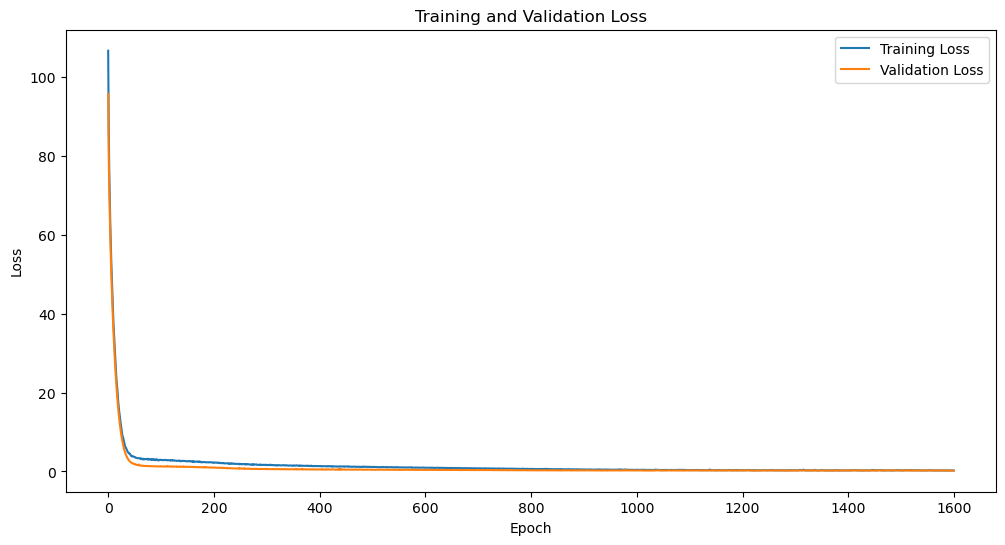

In [17]:
# 绘制损失曲线
plt.figure(figsize=(12, 6))
plt.plot(train_loss_B, label='Training Loss')
plt.plot(val_loss_B, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_curve_modelB.png')
plt.show()

In [18]:
model_A.save('model_A.keras')
model_B.save('model_B.keras')

In [19]:
bst_A = xgb.Booster()
bst_B = xgb.Booster()
bst_A.load_model('xgboost_model1.model')
bst_B.load_model('xgboost_model2.model')

In [20]:
lstm_A_predictions = model_A.predict(X_A)
lstm_B_predictions = model_B.predict(X_B)
print(lstm_A_predictions)
print(lstm_B_predictions)

60/60 [==============================] - 1s 1ms/step
[[0.15003103 2.917726   2.7821782  2.8754895  4.614591   4.5183673 ]
 [0.13817972 3.0161717  2.8878074  2.9759362  4.6194205  4.5192    ]
 [0.0674454  3.0620713  2.7978015  2.8953543  4.6229405  4.51564   ]
 ...
 [0.05339986 1.6743501  1.4962232  1.6624719  4.6214933  4.5127172 ]
 [0.13870347 3.0054755  2.873311   2.9621723  4.619758   4.518995  ]
 [6.8997507  2.2379265  2.048583   2.1722357  4.4393654  4.491382  ]]
[[ 4.5655327  4.33927    4.1722403 ... 20.503334  25.715607  26.75565  ]
 [ 4.5632715  4.4616823  3.2440798 ... 20.281826  25.544456  25.953245 ]
 [ 4.5748963  4.6533895  4.2522907 ... 19.831621  23.38964   23.83393  ]
 ...
 [ 4.508816   4.217229   2.565286  ... 21.357166  27.601976  27.465792 ]
 [ 4.5151663  4.4291563  2.6915708 ... 20.732761  27.24249   26.826307 ]
 [ 4.567225   4.611163   4.2384624 ... 19.848913  23.639534  24.162395 ]]


In [35]:
def plot_confusion_matrix(conf_matrix, class_names, model_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [21]:
dtest_true_A = xgb.DMatrix(y_A)
dtest_true_B = xgb.DMatrix(y_B)
xgb_true_A_predictions = bst_A.predict(dtest_true_A)
xgb_true_B_predictions = bst_B.predict(dtest_true_B)
xgb_true_A_predictions = [1 if i > 0.5 else 0 for i in xgb_true_A_predictions]
xgb_true_B_predictions = [1 if i > 0.5 else 0 for i in xgb_true_B_predictions]
dtest_LSTM_A = xgb.DMatrix(lstm_A_predictions)
dtest_LSTM_B = xgb.DMatrix(lstm_B_predictions)
xgb_A_predictions_LSTM = bst_A.predict(dtest_LSTM_A)
xgb_B_predictions_LSTM = bst_B.predict(dtest_LSTM_B)
xgb_A_predictions_LSTM = [1 if i > 0.5 else 0 for i in xgb_A_predictions_LSTM]
xgb_B_predictions_LSTM = [1 if i > 0.5 else 0 for i in xgb_B_predictions_LSTM]
correct_predictions_A_LSTM = sum([1 if pred == true else 0 for pred, true in zip(xgb_A_predictions_LSTM, xgb_true_A_predictions)])
correct_predictions_B_LSTM = sum([1 if pred == true else 0 for pred, true in zip(xgb_B_predictions_LSTM, xgb_true_B_predictions)])
accuracy_A_LSTM = correct_predictions_A_LSTM / len(xgb_true_A_predictions)
accuracy_B_LSTM = correct_predictions_B_LSTM / len(xgb_true_B_predictions)
print(xgb_A_predictions_LSTM)
print(xgb_true_A_predictions)
print(xgb_B_predictions_LSTM)
print(xgb_true_B_predictions)
print(f"Accuracy for model A: {accuracy_A_LSTM * 100:.2f}%")
print(f"Accuracy for model B: {accuracy_B_LSTM * 100:.2f}%")

[0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

A Data - Recall LSTM-GAN: 0.61
A Data - F1 Score LSTM-GAN: 0.69
Confusion Matrix:


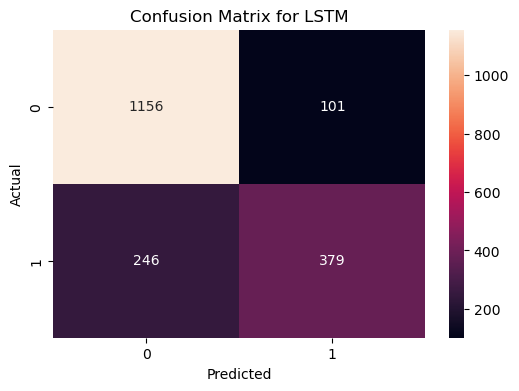

In [36]:
recall_A_LSTM = recall_score(xgb_true_A_predictions, xgb_A_predictions_LSTM)
f1_A_LSTM_GAN = f1_score(xgb_true_A_predictions, xgb_A_predictions_LSTM)
conf_matrix_A_LSTM = confusion_matrix(xgb_true_A_predictions, xgb_A_predictions_LSTM)
print(f"A Data - Recall LSTM-GAN: {recall_A_LSTM:.2f}")
print(f"A Data - F1 Score LSTM-GAN: {f1_A_LSTM_GAN:.2f}")
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix_A_LSTM, class_names=['0', '1'], model_name='LSTM-A')

A Data - Recall LSTM-GAN: 0.78
A Data - F1 Score LSTM-GAN: 0.79
Confusion Matrix:


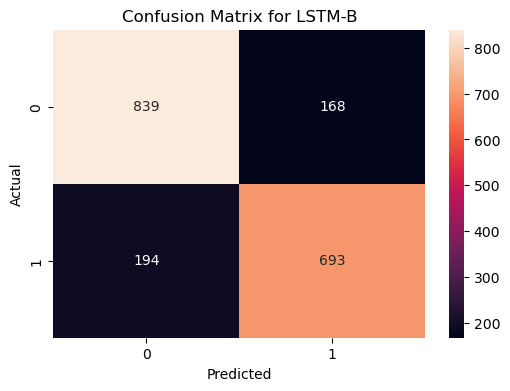

In [37]:
recall_B_LSTM = recall_score(xgb_true_B_predictions, xgb_B_predictions_LSTM)
f1_B_LSTM_GAN = f1_score(xgb_true_B_predictions, xgb_B_predictions_LSTM)
conf_matrix_B_LSTM = confusion_matrix(xgb_true_B_predictions, xgb_B_predictions_LSTM)
print(f"A Data - Recall LSTM-GAN: {recall_B_LSTM:.2f}")
print(f"A Data - F1 Score LSTM-GAN: {f1_B_LSTM_GAN:.2f}")
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix_B_LSTM, class_names=['0', '1'], model_name='LSTM-B')

##### LSTM-GAN模型

In [22]:
# # 定义A模型生成器（Generator）
# def build_generator_creat_A():
#     model = Sequential()
#     model.add(LSTM(128, return_sequences=True, input_shape=(5, 50)))  # 添加 input_shape
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dropout(0.2))
#     model.add(LSTM(64, return_sequences=True))  # 添加 input_shape
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dropout(0.2))
#     model.add(LSTM(32, return_sequences=True))  # 添加 input_shape
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dropout(0.2))
#     # model.add(LSTM(6, activation='relu', return_sequences=True))  # 添加 input_shape
#     # model.add(LeakyReLU(alpha=0.2))
#     # model.add(BatchNormalization(momentum=0.8))
#     # model.add(Dropout(0.2))
#     # model.add(TimeDistributed(Dense(10, activation='linear')))
#     # model.add(LeakyReLU(alpha=0.2))
#     # model.add(BatchNormalization(momentum=0.8))
#     # model.add(Dropout(0.2))
#     model.add(TimeDistributed(Dense(6)))
#     # model.add(BatchNormalization(momentum=0.8))
#     model.add(Dropout(0.2))
#     return model

# # 定义A模型判别器（Discriminator）
# def build_discriminator_creat_A():
#     model = Sequential()
#     # kernel_initializer='he_normal'
#     model.add(LSTM(40, return_sequences=True, input_shape=(5, 6)))  # 添加 input_shape
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dropout(0.2))
#     model.add(LSTM(15, return_sequences=True))  # 添加 input_shape
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dropout(0.2))
#     model.add(LSTM(10, return_sequences=False))  # 添加 input_shape
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dropout(0.2))
#     # model.add(Dense(16))
#     # model.add(LeakyReLU(alpha=0.2))
#     # model.add(BatchNormalization(momentum=0.8))
#     # model.add(Dropout(0.2))
#     model.add(Dense(1, activation='sigmoid'))
#     # model.add(BatchNormalization(momentum=0.8))
#     # model.add(Dropout(0.2))
#     return model

# # 定义B模型生成器（Generator）
# def build_generator_creat_B():
#     model = Sequential()
#     model.add(LSTM(50, return_sequences=True, input_shape=(5, 100)))  # 添加 input_shape
#     model.add(LeakyReLU())
#     model.add(Dropout(0.2))
#     model.add(LSTM(20, return_sequences=True))  # 确保只返回最后一个输出
#     model.add(LeakyReLU())
#     model.add(Dropout(0.2))
#     model.add(TimeDistributed(Dense(17, activation='relu')))
#     return model

# # 定义B模型判别器（Discriminator）
# def build_discriminator_creat_B():
#     model = Sequential()
#     model.add(LSTM(50, return_sequences=True, input_shape=(5, 17)))  # 添加 input_shape
#     model.add(LeakyReLU())
#     model.add(Dropout(0.2))
#     model.add(LSTM(20, return_sequences=True))  # 确保只返回最后一个输出
#     model.add(LeakyReLU())
#     model.add(Dropout(0.2))
#     model.add(LSTM(10, return_sequences=False))  # 确保只返回最后一个输出
#     model.add(LeakyReLU())
#     model.add(Dropout(0.2))
#     model.add(Dense(1, activation='sigmoid'))
#     return model

# # 定义LSTM-GAN模型
# def build_lstm_gan_creat(generator, discriminator):
#     discriminator.trainable = False
#     model = Sequential()
#     model.add(generator)
#     model.add(discriminator)
#     return model

# def generate_noise(n_samples, n_timesteps, noise_dim):
#     return np.random.normal(0, 1, size=(n_samples, n_timesteps, noise_dim))



In [23]:
# def train_lstm_gan_creat(gan_model, generator, discriminator, data, epochs, batch_size):
#     for epoch in range(epochs):
#         noise = generate_noise(batch_size, 5, 50)
#         idx = np.random.randint(0, data.shape[0], batch_size)
#         real_data = data[idx]
#         # 训练判别器
#         discriminator.trainable = True
#         fake_data = generator.predict(noise, verbose=0)  # 生成假数据
#         real_y = np.ones((batch_size, 1))
#         fake_y = np.zeros((batch_size, 1))

#         d_loss_real = discriminator.train_on_batch(real_data, real_y)
#         d_loss_fake = discriminator.train_on_batch(fake_data, fake_y)
#         d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#         # 训练生成器
#         discriminator.trainable = False
#         g_loss = gan_model.train_on_batch(noise, real_y)  # 输入的是噪声，而不是生成的数据和噪声的组合

#         if epoch % 100 == 0:
#             print(f"Epoch: {epoch} \t Discriminator Loss: {d_loss}\t\t Generator Loss: {g_loss}")

In [ ]:
# def sequence_loss(y_true, y_pred):
#     element_loss = keras.losses.mean_squared_error(y_true, y_pred)
#     sequence_loss = keras.backend.mean(element_loss, axis=-1)
#     return sequence_loss
# def wasserstein_loss(y_true, y_pred):
#     return K.mean(y_true * y_pred)
opt_creat_dis_A = Adam(learning_rate=0.001, clipvalue=1.0)
opt_creat_gan_A = Adam(learning_rate=0.001, clipvalue=1.0)
generator_creat_A = build_generator_creat_A()
discriminator_creat_A = build_discriminator_creat_A()

gan_model_creat_A = build_lstm_gan_creat(generator_creat_A, discriminator_creat_A)
plot_model(generator_creat_A, to_file='generator_creat_A.png', show_shapes=True, show_dtype=True)
plot_model(discriminator_creat_A, to_file='discriminator_creat_A.png', show_shapes=True, show_dtype=True)
plot_model(gan_model_creat_A, to_file='gan_model_A.png', show_shapes=True, show_dtype=True)
# loss='binary_crossentropy'
discriminator_creat_A.compile(loss='binary_crossentropy', optimizer=opt_creat_dis_A)
gan_model_creat_A.compile(loss='mse', optimizer=opt_creat_gan_A)

train_lstm_gan_creat(gan_model_creat_A, generator_creat_A, discriminator_creat_A, data_fault_A, epochs=10000, batch_size=32)

In [ ]:
# # 生成A类型磁盘故障数据
# noise_A = generate_noise(2000, 5, 50)
# generated_sample_A = generator_creat_A.predict(noise_A)
# print(generated_sample_A)
# print(generated_sample_A.shape)

63/63 [==============================] - 3s 33ms/step
[[[ 1.74641004e-03  2.21318752e-03 -3.65705520e-04  8.56168568e-04
   -1.36733172e-04  4.02431033e-04]
  [ 1.28217693e-03  1.32157432e-03 -7.91108294e-04  4.48456354e-04
   -2.65225652e-04  4.81402269e-04]
  [ 8.23458889e-04  7.43045239e-04 -1.13404379e-03  2.76314502e-04
   -3.92028422e-04  4.82689124e-04]
  [-4.32180241e-05 -3.23459972e-05 -1.26363500e-03  4.14663111e-04
   -7.22235884e-04  2.35760846e-04]
  [-1.87226501e-03  6.84234081e-04 -2.82904977e-04  8.60915985e-04
   -1.45537092e-03 -1.26135256e-03]]

 [[ 1.70817715e-03  2.26123072e-03 -3.71356000e-04  8.82245018e-04
   -1.27405045e-04  3.52134753e-04]
  [ 1.38133287e-03  1.43034128e-03 -7.61730422e-04  4.79920069e-04
   -2.00541326e-04  4.36539529e-04]
  [ 1.15875225e-03  8.85921938e-04 -1.19417906e-03  4.54815425e-04
   -2.15694658e-04  2.96459271e-04]
  [ 5.24191360e-04  2.71142460e-04 -8.56668048e-04  9.11878014e-04
   -2.13102350e-04 -5.59501408e-04]
  [-4.56998823e-0

In [ ]:
# # 判断生成的数据是否为故障数据
# bst_fault_A = xgb.Booster()  # 初始化模型
# bst_fault_A.load_model('xgboost_model1.model')  # 加载模型
# generated_sample_predict_A = generated_sample_A.reshape(-1, generated_sample_A.shape[2])
# print(generated_sample_predict_A.shape)
# # XGBoost需要的是DMatrix格式的数据
# dtest = xgb.DMatrix(generated_sample_predict_A)
# # 使用模型进行预测
# preds = bst_fault_A.predict(dtest)
# print(preds)
# preds = [1 if i > 0.5 else 0 for i in preds]
# print(preds)
# one_count = []
# for norm in preds:
#     if norm == 1:
#         one_count.append(norm)
# print(len(one_count))

(10000, 6)
[0.99983   0.9961867 0.9959045 ... 0.9959045 0.9959045 0.9959045]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

(882, 5, 6)


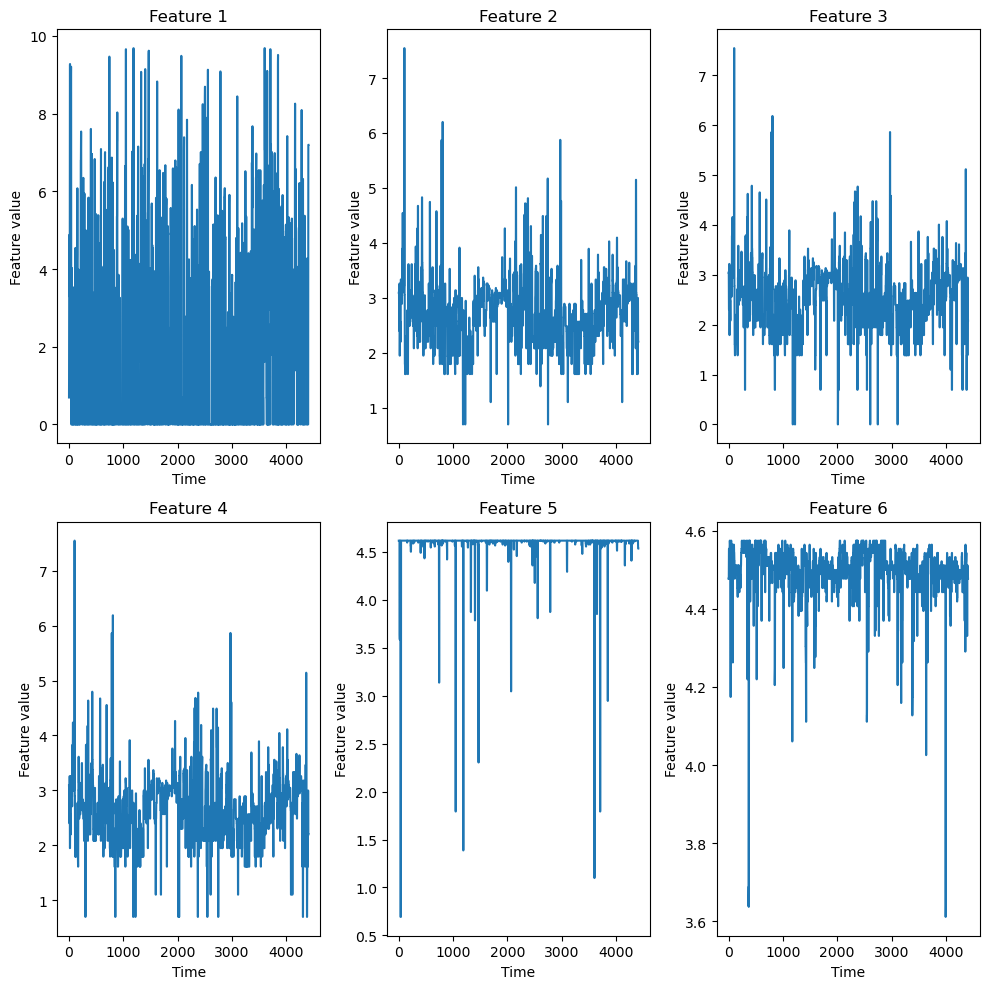

In [ ]:
# print(data_fault_A.shape)

# # 定义子图的行数和列数
# nrows = 2
# ncols = 3
# fig, axs = plt.subplots(nrows, ncols, figsize=(10, 10))

# for feature_index in range(data_fault_A.shape[2]):

#     # 初始化一个空的列表来保存这个特性的所有值
#     feature_values = []

#     # 遍历数据集中的所有5*6数组
#     for array in data_fault_A:
#         # 对每个5*6数组，取出当前特性的值，然后添加到列表中
#         feature_values.extend(array[:, feature_index])

#     # 创建一个时间序列，从0开始，间隔为1
#     time = np.arange(len(feature_values))

#     # 找到对应的子图索引
#     row_index = feature_index // ncols
#     col_index = feature_index % ncols

#     # 绘制当前特性的时间序列图到对应的子图
#     axs[row_index, col_index].plot(time, feature_values, label=f'Feature {feature_index+1}')
#     axs[row_index, col_index].set_title(f'Feature {feature_index+1}')
#     axs[row_index, col_index].set_xlabel("Time")
#     axs[row_index, col_index].set_ylabel("Feature value")

# # 显示图形
# plt.tight_layout()
# plt.show()


(2000, 5, 6)


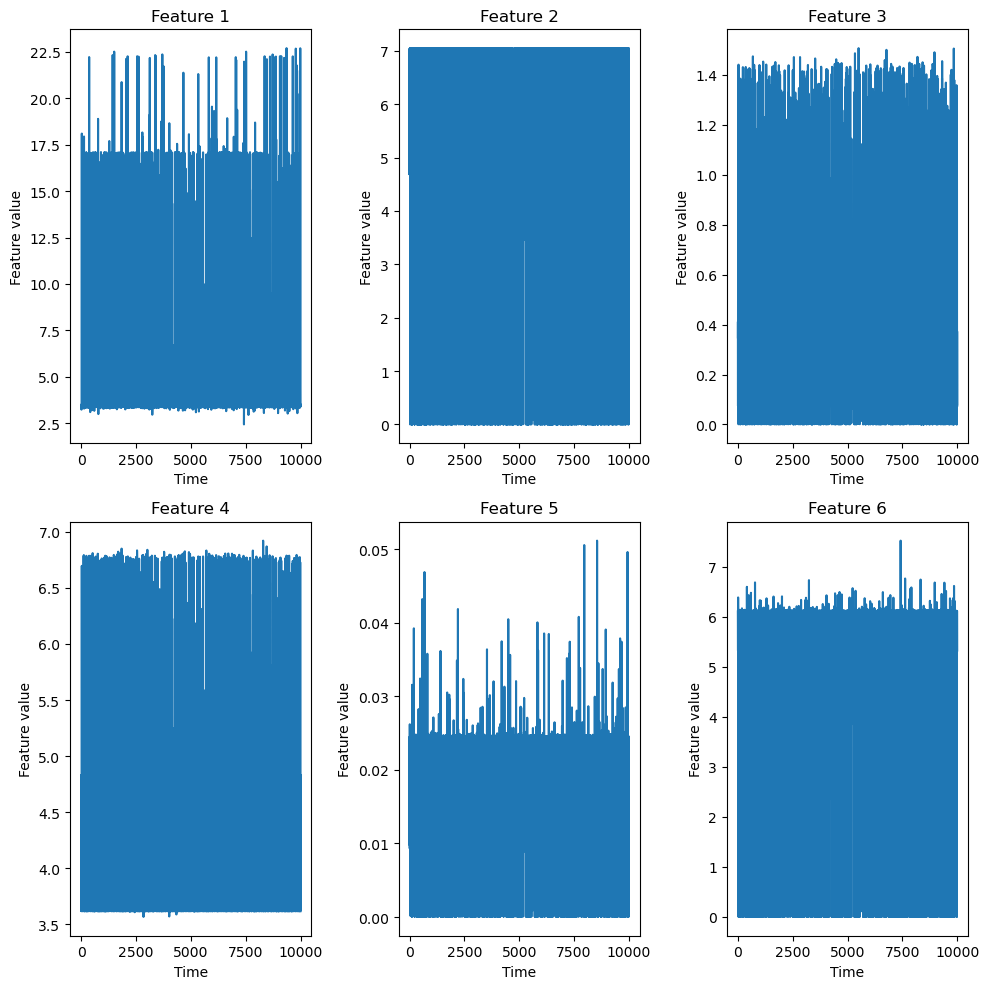

In [ ]:
# print(generated_sample_A.shape)

# # 定义子图的行数和列数
# nrows = 2
# ncols = 3
# fig, axs = plt.subplots(nrows, ncols, figsize=(10, 10))

# for feature_index in range(generated_sample_A.shape[2]):

#     # 初始化一个空的列表来保存这个特性的所有值
#     feature_values = []

#     # 遍历数据集中的所有5*6数组
#     for array in generated_sample_A:
#         # 对每个5*6数组，取出当前特性的值，然后添加到列表中
#         feature_values.extend(array[:, feature_index])

#     # 创建一个时间序列，从0开始，间隔为1
#     time = np.arange(len(feature_values))

#     # 找到对应的子图索引
#     row_index = feature_index // ncols
#     col_index = feature_index % ncols

#     # 绘制当前特性的时间序列图到对应的子图
#     axs[row_index, col_index].plot(time, feature_values, label=f'Feature {feature_index+1}')
#     axs[row_index, col_index].set_title(f'Feature {feature_index+1}')
#     axs[row_index, col_index].set_xlabel("Time")
#     axs[row_index, col_index].set_ylabel("Feature value")

# # 显示图形
# plt.tight_layout()
# plt.show()


In [ ]:
# opt_creat_B = Adam(learning_rate=0.0005, beta_1=0.9)

# generator_creat_B = build_generator_creat_B()

# discriminator_creat_B = build_discriminator_creat_B()
# gan_model_creat_B = build_lstm_gan_creat(generator_creat_B, discriminator_creat_B)
# plot_model(generator_creat_B, to_file='generator_creat_B.png', show_shapes=True, show_dtype=True)
# plot_model(discriminator_creat_B, to_file='discriminator_creat_B.png', show_shapes=True, show_dtype=True)
# plot_model(gan_model_creat_B, to_file='gan_model_B.png', show_shapes=True, show_dtype=True)
# gan_model_creat_B.compile(loss='binary_crossentropy', optimizer=opt_creat_B)
# discriminator_creat_B.compile(loss='binary_crossentropy', optimizer=opt_creat_B)

# # 假设 X_A 是前四天的数据, y_A 是第五天的数据
# train_lstm_gan_creat(gan_model_creat_B, generator_creat_B, discriminator_creat_B, data_fault_B, epochs=3000, batch_size=16)

Epoch: 0 	 Discriminator Loss: 0.7288603782653809		 Generator Loss: 0.6941140294075012
Epoch: 100 	 Discriminator Loss: 0.7318967580795288		 Generator Loss: 0.6917126178741455
Epoch: 200 	 Discriminator Loss: 0.7351740598678589		 Generator Loss: 0.6782277822494507
Epoch: 300 	 Discriminator Loss: 0.7422788143157959		 Generator Loss: 0.6683787703514099
Epoch: 400 	 Discriminator Loss: 0.7429929375648499		 Generator Loss: 0.661432683467865
Epoch: 500 	 Discriminator Loss: 0.7524667680263519		 Generator Loss: 0.6623350977897644
Epoch: 600 	 Discriminator Loss: 0.7430430054664612		 Generator Loss: 0.6615584492683411
Epoch: 700 	 Discriminator Loss: 0.7419480085372925		 Generator Loss: 0.6528778076171875
Epoch: 800 	 Discriminator Loss: 0.7576324939727783		 Generator Loss: 0.6552607417106628
Epoch: 900 	 Discriminator Loss: 0.7524260878562927		 Generator Loss: 0.6578803658485413
Epoch: 1000 	 Discriminator Loss: 0.7550116181373596		 Generator Loss: 0.6553072929382324
Epoch: 1100 	 Discrimin

In [ ]:
# # 生成B类型磁盘故障数据
# noise_B = generate_noise(10000, 5, 100)
# generated_sample_B = generator_creat_B.predict(noise_B)
# print(generated_sample_B)
# print(generated_sample_B.shape)

313/313 [==============================] - 9s 28ms/step
[[[ 0.        25.844664  21.641989  ...  0.         6.4691515  0.       ]
  [ 0.        31.923485  26.921253  ...  0.         7.966381   0.       ]
  [ 0.        32.855194  27.730402  ...  0.         8.195865   0.       ]
  [ 0.        32.983555  27.84188   ...  0.         8.22748    0.       ]
  [ 0.        33.000973  27.857008  ...  0.         8.2317705  0.       ]]

 [[ 0.        25.846682  21.64376   ...  0.         6.4696484  0.       ]
  [ 0.        31.923676  26.921417  ...  0.         7.9664307  0.       ]
  [ 0.        32.855217  27.730429  ...  0.         8.195869   0.       ]
  [ 0.        32.983555  27.841883  ...  0.         8.227481   0.       ]
  [ 0.        33.000973  27.857006  ...  0.         8.2317705  0.       ]]

 [[ 0.        25.846554  21.643627  ...  0.         6.469614   0.       ]
  [ 0.        31.923635  26.921381  ...  0.         7.966419   0.       ]
  [ 0.        32.855213  27.73042   ...  0.         

In [ ]:
# # 判断生成的数据是否为故障数据
# bst_fault_B = xgb.Booster()  # 初始化模型
# bst_fault_B.load_model('xgboost_model2.model')  # 加载模型
# generated_sample_predict_B = generated_sample_B.reshape(-1, generated_sample_B.shape[2])
# print(generated_sample_predict_B.shape)
# # XGBoost需要的是DMatrix格式的数据
# dtest = xgb.DMatrix(generated_sample_predict_B)
# # 使用模型进行预测
# preds = bst_fault_B.predict(dtest)
# print(preds)
# preds = [1 if i > 0.5 else 0 for i in preds]
# print(preds)

(50000, 17)
[0.97916806 0.9972703  0.9958554  ... 0.9958554  0.9958554  0.9958554 ]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

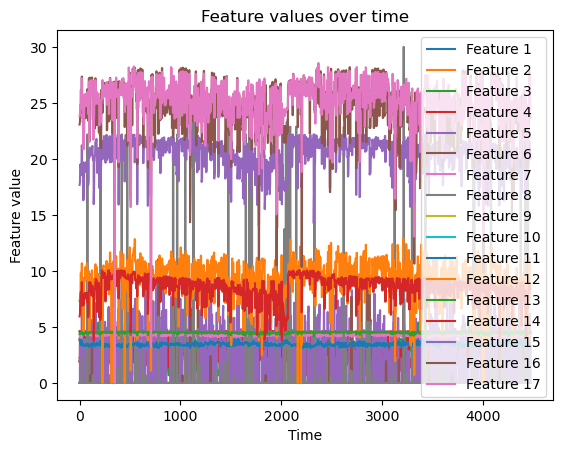

In [ ]:
# for feature_index in range(data_fault_B.shape[2]):

#     # 初始化一个空的列表来保存这个特性的所有值
#     feature_values = []

#     # 遍历数据集中的所有5*6数组
#     for array in data_fault_B:
#         # 对每个5*6数组，取出当前特性的值，然后添加到列表中
#         feature_values.extend(array[:, feature_index])

#     # 创建一个时间序列，从0开始，间隔为1
#     time = np.arange(len(feature_values))

#     # 绘制当前特性的时间序列图
#     plt.plot(time, feature_values, label=f'Feature {feature_index+1}')

# # 添加标题和标签
# plt.title("Feature values over time")
# plt.xlabel("Time")
# plt.ylabel("Feature value")

# # 添加图例
# plt.legend()

# # 显示图形
# plt.show()

c:\Users\90515\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


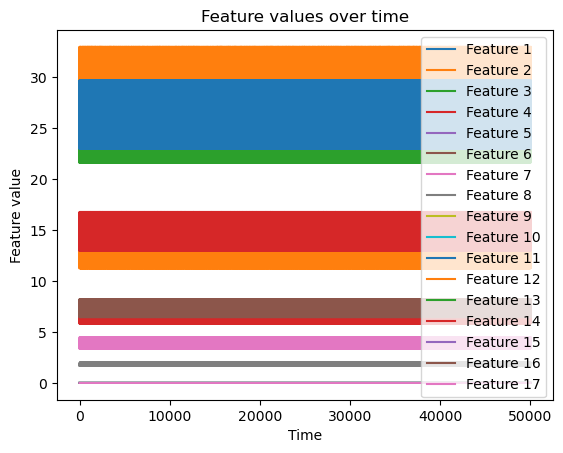

In [ ]:
# for feature_index in range(generated_sample_B.shape[2]):

#     # 初始化一个空的列表来保存这个特性的所有值
#     feature_values = []

#     # 遍历数据集中的所有5*6数组
#     for array in generated_sample_B:
#         # 对每个5*6数组，取出当前特性的值，然后添加到列表中
#         feature_values.extend(array[:, feature_index])

#     # 创建一个时间序列，从0开始，间隔为1
#     time = np.arange(len(feature_values))

#     # 绘制当前特性的时间序列图
#     plt.plot(time, feature_values, label=f'Feature {feature_index+1}')

# # 添加标题和标签
# plt.title("Feature values over time")
# plt.xlabel("Time")
# plt.ylabel("Feature value")

# # 添加图例
# plt.legend()

# # 显示图形
# plt.show()

In [25]:
# 定义A模型生成器（Generator）
def build_generator_A():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(4, 6)))  # 添加 input_shape
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    # model.add(LSTM(60, return_sequences=True))
    # model.add(LeakyReLU())
    # model.add(Dropout(0.2))
    # model.add(LSTM(30, return_sequences=True))
    # model.add(LeakyReLU())
    # model.add(Dropout(0.2))
    model.add(LSTM(15, return_sequences=False))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Dense(6))  # 预测下一步的6个特征
    model.add(LeakyReLU())
    return model

# 定义A模型判别器（Discriminator）
def build_discriminator_A():
    model = Sequential()
    model.add(LSTM(120, return_sequences=True, input_shape=(5, 6)))  # 添加 input_shape
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(LSTM(60, return_sequences=True))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(LSTM(30, return_sequences=True))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(LSTM(15, return_sequences=False))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    # model.add(Dense(6))
    # model.add(LeakyReLU())
    # model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# 定义B模型生成器（Generator）
def build_generator_B():
    model = Sequential()
    model.add(LSTM(240, return_sequences=True, input_shape=(4, 17)))  # 添加 input_shape
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(LSTM(120, return_sequences=True))  # 确保只返回最后一个输出
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(LSTM(60, return_sequences=True))  # 确保只返回最后一个输出
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(LSTM(30, return_sequences=False))  # 确保只返回最后一个输出
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Dense(17))  # 预测下一步的17个特征
    model.add(LeakyReLU())
    return model

# 定义B模型判别器（Discriminator）
def build_discriminator_B():
    model = Sequential()
    model.add(LSTM(240, return_sequences=True, input_shape=(5, 17)))  # 添加 input_shape
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(LSTM(120, return_sequences=True))  # 确保只返回最后一个输出
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(LSTM(60, return_sequences=True))  # 确保只返回最后一个输出
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(LSTM(15, return_sequences=False))  # 确保只返回最后一个输出
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    # model.add(Dense(6))
    # model.add(LeakyReLU())
    # model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# 定义LSTM-GAN模型
def build_lstm_gan_A(generator, discriminator):
    discriminator.trainable = False
    z = Input(shape=(4, 6))  # 这是生成器的输入
    gen_output = generator(z)
    # 将生成器的输出调整为与输入相同的维度
    gen_output_reshaped = Lambda(lambda x: Reshape((1, 6))(x))(gen_output)
    # 将生成器的输入和输出连接起来
    merged = Concatenate(axis=1)([z, gen_output_reshaped])
    discriminator_output = discriminator(merged)
    gan = Model(z, discriminator_output)
    return gan

def build_lstm_gan_B(generator, discriminator):
    discriminator.trainable = False
    z = Input(shape=(4, 17))  # 这是生成器的输入
    gen_output = generator(z)
    # 将生成器的输出调整为与输入相同的维度
    gen_output_reshaped = Lambda(lambda x: Reshape((1, 17))(x))(gen_output)
    # 将生成器的输入和输出连接起来
    merged = Concatenate(axis=1)([z, gen_output_reshaped])
    discriminator_output = discriminator(merged)
    gan = Model(z, discriminator_output)
    return gan



In [26]:
def train_lstm_gan(gan_model, generator, discriminator, X, data, epochs, batch_size):
    d_losses = []
    g_losses = []
    for epoch in range(epochs):
        # 随机选择一批数据
        idx = np.random.randint(0, X.shape[0], batch_size)
        noise = X[idx]  # 使用前四天的数据作为噪声
        real_data = data[idx]  # 真实的5天数据
        # 训练判别器
        discriminator.trainable = True
        fake_data_5th_day = generator.predict(noise, verbose=0)  # 生成假的第五天数据
        # print(fake_data_5th_day.shape)
        # print(noise.shape)
        fake_data_5th_day_expanded = fake_data_5th_day[:, np.newaxis, :]  # 增加一个新维度使其成为3D数组
        fake_data = np.concatenate((noise, fake_data_5th_day_expanded), axis=1)  # 将假数据与噪声结合
        # print(fake_data.shape)
        # print(real_data.shape)
        real_y = np.ones((batch_size, 1))
        fake_y = np.zeros((batch_size, 1))
        # print(fake_y.shape)
        d_loss_real = discriminator.train_on_batch(real_data, real_y)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_y)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # 训练生成器
        discriminator.trainable = False
        g_loss = gan_model.train_on_batch(noise, real_y)  # 输入的是噪声，而不是生成的数据和噪声的组合

        d_losses.append(d_loss)
        g_losses.append(g_loss)

        if (epoch%100==0):
            print(f"Epoch: {epoch} \t Discriminator Loss: {d_loss}, \t\t Generator Loss: {g_loss}")

    return d_losses, g_losses


Epoch: 0 	 Discriminator Loss: 0.6931766271591187, 		 Generator Loss: 0.2520340085029602
Epoch: 100 	 Discriminator Loss: 0.6930052936077118, 		 Generator Loss: 0.2518385052680969
Epoch: 200 	 Discriminator Loss: 0.6928019225597382, 		 Generator Loss: 0.2524670958518982
Epoch: 300 	 Discriminator Loss: 0.6932931840419769, 		 Generator Loss: 0.25096574425697327
Epoch: 400 	 Discriminator Loss: 0.6933603882789612, 		 Generator Loss: 0.2516544759273529
Epoch: 500 	 Discriminator Loss: 0.6934020221233368, 		 Generator Loss: 0.2517443895339966
Epoch: 600 	 Discriminator Loss: 0.6930981278419495, 		 Generator Loss: 0.25144079327583313
Epoch: 700 	 Discriminator Loss: 0.6934291422367096, 		 Generator Loss: 0.25202223658561707
Epoch: 800 	 Discriminator Loss: 0.693763256072998, 		 Generator Loss: 0.2516334056854248
Epoch: 900 	 Discriminator Loss: 0.6934745013713837, 		 Generator Loss: 0.2515189051628113


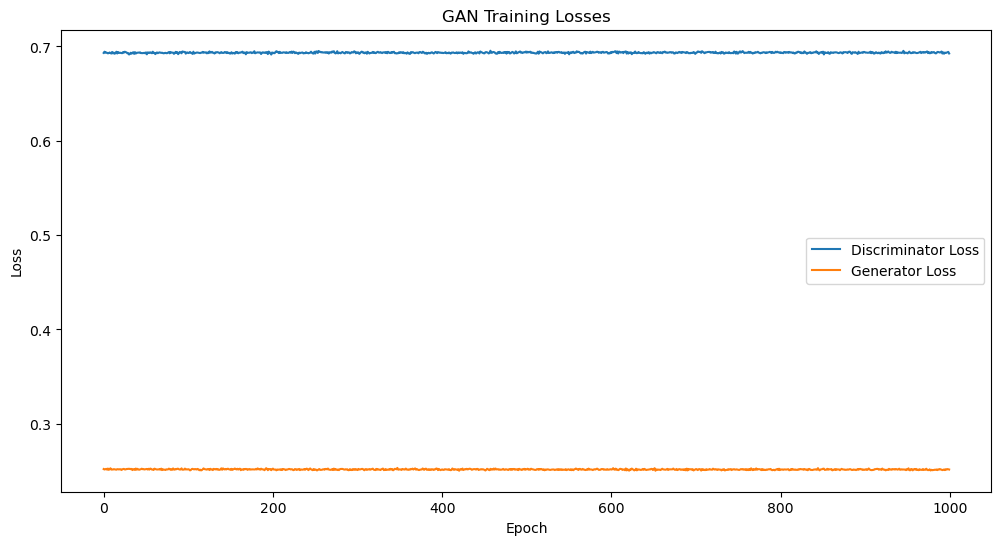

In [41]:
opt_A = Adam(learning_rate=0.01)

generator_A = build_generator_A()
discriminator_A = build_discriminator_A()

gan_model_A = build_lstm_gan_A(generator_A, discriminator_A)
plot_model(generator_A, to_file='generator_A.png', show_shapes=True, show_dtype=True)
plot_model(discriminator_A, to_file='discriminator_A.png', show_shapes=True, show_dtype=True)
plot_model(gan_model_A, to_file='gan_model_A.png', show_shapes=True, show_dtype=True)
gan_model_A.compile(loss='mse', optimizer=opt_A)
discriminator_A.compile(loss='binary_crossentropy', optimizer=opt_A)

# 假设 X_A 是前四天的数据, y_A 是第五天的数据
d_losses_A, g_losses_A = train_lstm_gan(gan_model_A, generator_A, discriminator_A, X_A, data_A, epochs=1000, batch_size=16)
plt.figure(figsize=(12, 6))
plt.plot(d_losses_A, label='Discriminator Loss')
plt.plot(g_losses_A, label='Generator Loss')
plt.title('GAN Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch: 0 	 Discriminator Loss: 0.6895484328269958, 		 Generator Loss: 0.24647784233093262
Epoch: 100 	 Discriminator Loss: 0.6949849426746368, 		 Generator Loss: 0.2469584047794342
Epoch: 200 	 Discriminator Loss: 0.695425271987915, 		 Generator Loss: 0.24377113580703735
Epoch: 300 	 Discriminator Loss: 0.6951281726360321, 		 Generator Loss: 0.24453744292259216
Epoch: 400 	 Discriminator Loss: 0.6957921385765076, 		 Generator Loss: 0.24512720108032227
Epoch: 500 	 Discriminator Loss: 0.6973007917404175, 		 Generator Loss: 0.24384120106697083
Epoch: 600 	 Discriminator Loss: 0.6945663690567017, 		 Generator Loss: 0.24342897534370422
Epoch: 700 	 Discriminator Loss: 0.6956970989704132, 		 Generator Loss: 0.2448512464761734
Epoch: 800 	 Discriminator Loss: 0.6967439651489258, 		 Generator Loss: 0.24463944137096405
Epoch: 900 	 Discriminator Loss: 0.6938857734203339, 		 Generator Loss: 0.2437206506729126


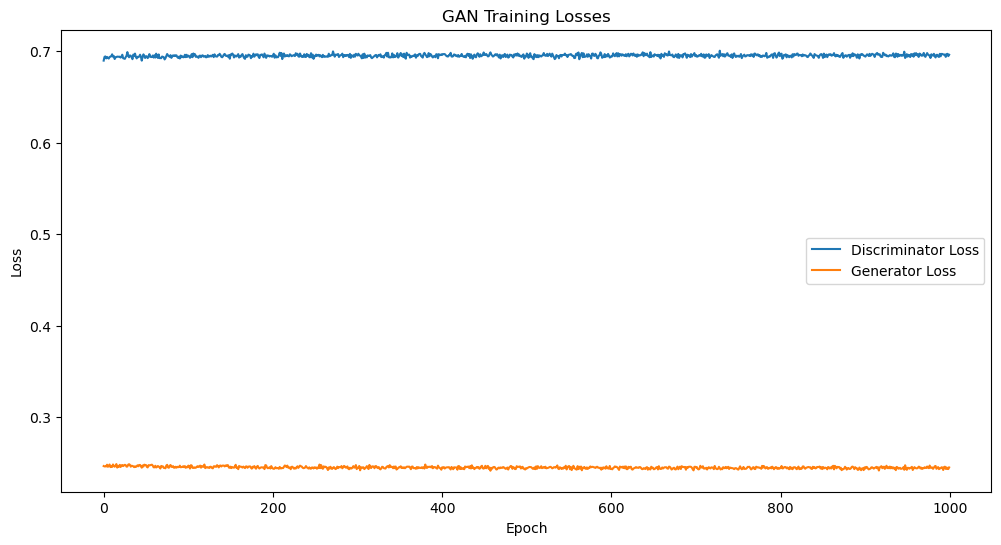

In [42]:
opt_B = Adam(learning_rate=0.01)

generator_B = build_generator_B()
discriminator_B = build_discriminator_B()

gan_model_B = build_lstm_gan_B(generator_B, discriminator_B)
plot_model(generator_B, to_file='generator_B.png', show_shapes=True, show_dtype=True)
plot_model(discriminator_B, to_file='discriminator_B.png', show_shapes=True, show_dtype=True)
plot_model(gan_model_B, to_file='gan_model_B.png', show_shapes=True, show_dtype=True)
gan_model_B.compile(loss='mse', optimizer=opt_B)
discriminator_B.compile(loss='binary_crossentropy', optimizer=opt_B)

# 假设 X_B 是前四天的数据, y_B 是第五天的数据
d_losses_B, g_losses_B = train_lstm_gan(gan_model_B, generator_B, discriminator_B, X_B, data_B, epochs=1000, batch_size=16)
plt.figure(figsize=(12, 6))
plt.plot(d_losses_B, label='Discriminator Loss')
plt.plot(g_losses_B, label='Generator Loss')
plt.title('GAN Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
gan_predictions_A = generator_A.predict(X_A)
gan_predictions_B = generator_B.predict(X_B)
print(gan_predictions_A)
print(gan_predictions_B)
dtest_true_A = xgb.DMatrix(y_A)
dtest_true_B = xgb.DMatrix(y_B)
xgb_true_A_predictions = bst_A.predict(dtest_true_A)
xgb_true_B_predictions = bst_B.predict(dtest_true_B)
xgb_true_A_predictions = [1 if i > 0.5 else 0 for i in xgb_true_A_predictions]
xgb_true_B_predictions = [1 if i > 0.5 else 0 for i in xgb_true_B_predictions]
dtest_LSTM_GAN_A = xgb.DMatrix(gan_predictions_A)
dtest_LSTM_GAN_B = xgb.DMatrix(gan_predictions_B)
xgb_A_predictions_LSTM_GAN = bst_A.predict(dtest_LSTM_GAN_A)
xgb_B_predictions_LSTM_GAN = bst_B.predict(dtest_LSTM_GAN_B)
xgb_A_predictions_LSTM_GAN = [1 if i > 0.5 else 0 for i in xgb_A_predictions_LSTM_GAN]
xgb_B_predictions_LSTM_GAN = [1 if i > 0.5 else 0 for i in xgb_B_predictions_LSTM_GAN] 
correct_predictions_A_LSTM_GAN = sum([1 if pred == true else 0 for pred, true in zip(xgb_A_predictions_LSTM_GAN, xgb_true_A_predictions)])
correct_predictions_B_LSTM_GAN = sum([1 if pred == true else 0 for pred, true in zip(xgb_B_predictions_LSTM_GAN, xgb_true_B_predictions)])
accuracy_A_LSTM_GAN = correct_predictions_A_LSTM_GAN / len(xgb_true_A_predictions)
accuracy_B_LSTM_GAN = correct_predictions_B_LSTM_GAN / len(xgb_true_B_predictions)
print(xgb_A_predictions_LSTM_GAN)
print(xgb_true_A_predictions)
print(xgb_B_predictions_LSTM_GAN)
print(xgb_true_B_predictions)
print(f"Accuracy for model A: {accuracy_A_LSTM_GAN * 100:.2f}%")
print(f"Accuracy for model B: {accuracy_B_LSTM_GAN * 100:.2f}%")

60/60 [==============================] - 3s 55ms/step
[[ 14.955661  -17.213789    7.6167736  -3.175223   54.864384    7.004571 ]
 [ 14.955691  -17.213823    7.616788   -3.1752298  54.864506    7.0045843]
 [ 14.95567   -17.213802    7.6167784  -3.1752255  54.86443     7.0045753]
 ...
 [ 14.955135  -17.213167    7.6165066  -3.1751106  54.862354    7.0043273]
 [ 14.9556875 -17.21382     7.6167865  -3.1752293  54.864494    7.004583 ]
 [ 14.9555435 -17.213644    7.616711   -3.1751988  54.863914    7.0045137]]
[[ 37.621502    -1.5267855   42.373367   ...  36.840256   -16.013426
   -0.33344787]
 [ 37.6215      -1.5267854   42.373367   ...  36.840256   -16.013426
   -0.33344787]
 [ 37.621487    -1.526785    42.37336    ...  36.84025    -16.013424
   -0.33344772]
 ...
 [ 37.621506    -1.5267855   42.373367   ...  36.84026    -16.013428
   -0.3334479 ]
 [ 37.621506    -1.5267855   42.373367   ...  36.84026    -16.013426
   -0.3334479 ]
 [ 37.62149     -1.5267851   42.37336    ...  36.84025    -1

A Data - Recall LSTM-GAN: 1.00
A Data - F1 Score LSTM-GAN: 0.50
Confusion Matrix:


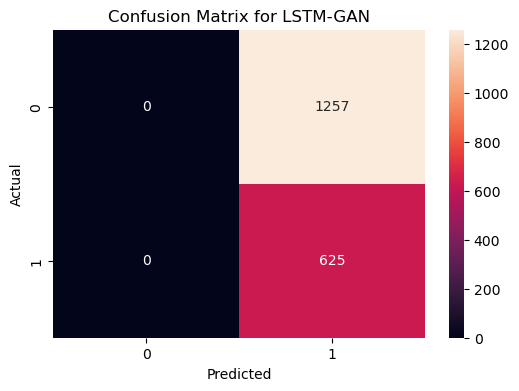

In [34]:
recall_A_LSTM_GAN = recall_score(xgb_true_A_predictions, xgb_A_predictions_LSTM_GAN)
f1_A_LSTM_GAN = f1_score(xgb_true_A_predictions, xgb_A_predictions_LSTM_GAN)
conf_matrix_A_LSTM_GAN = confusion_matrix(xgb_true_A_predictions, xgb_A_predictions_LSTM_GAN)
print(f"A Data - Recall LSTM-GAN: {recall_A_LSTM_GAN:.2f}")
print(f"A Data - F1 Score LSTM-GAN: {f1_A_LSTM_GAN:.2f}")
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix_A_LSTM_GAN, class_names=['0', '1'], model_name='LSTM-GAN')

A Data - Recall LSTM-GAN: 1.00
A Data - F1 Score LSTM-GAN: 0.64
Confusion Matrix:


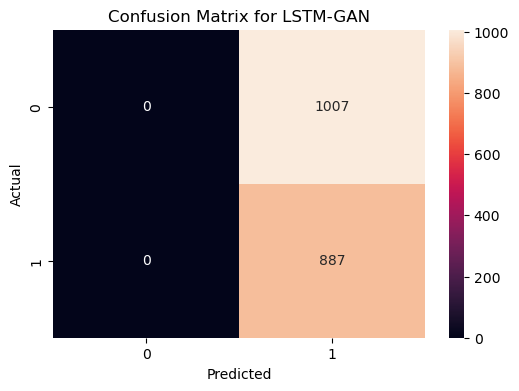

In [38]:
recall_B_LSTM_GAN = recall_score(xgb_true_B_predictions, xgb_B_predictions_LSTM_GAN)
f1_B_LSTM_GAN = f1_score(xgb_true_B_predictions, xgb_B_predictions_LSTM_GAN)
conf_matrix_B_LSTM_GAN = confusion_matrix(xgb_true_B_predictions, xgb_B_predictions_LSTM_GAN)
print(f"A Data - Recall LSTM-GAN: {recall_B_LSTM_GAN:.2f}")
print(f"A Data - F1 Score LSTM-GAN: {f1_B_LSTM_GAN:.2f}")
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix_B_LSTM_GAN, class_names=['0', '1'], model_name='LSTM-GAN')